[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MeteoSwiss/opendata-nwp-demos/blob/main/04_calculate_rel_humidity.ipynb)

# Calculate Relative Humidity from the Direct Model Outputs of ICON-CH2-EPS

This notebook demonstrates the full workflow for retrieving deterministic ICON-CH2-EPS forecasts and computing the relative humidity. The data is provided by MeteoSwiss as part of Switzerland’s  [Open Government Data (OGD) initiative](https://www.meteoswiss.admin.ch/services-and-publications/service/open-data.html).

Relative humidity is a commonly requested variable in weather analysis, though it is not directly provided by ICON-CH2-EPS. Instead, it must be derived from raw model outputs: specific humidity, temperature, and pressure. Fortunately, the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library includes a dedicated `relhum()` function that allows you to compute relative humidity quickly, making this derived product accessible for further analysis or visualization.

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed by MeteoSwiss to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as computing relative humidity and regridding.

For visualization, this notebook uses the [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html) library developed by ECMWF, which offers intuitive plotting tools for meteorological data.

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️ **Retrieve**  
    Fetch deterministic ICON-CH2-EPS forecast data (here specific humidity (`QV`), temperature (`T`) and pressure (`P`)) using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `ogd_api` module.

 📐 **Calculate**  
    Calculate relative humidity using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `relhum` module.

 🧭 **Regrid**  
    Interpolate ICON-CH2-EPS data from its native, icosahedral grid to the regular latitude/longitude grid [WGS84 (EPSG:4326)](https://epsg.io/4326).

 🌍 **Visualize**  
    Plot the processed data on a map using [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html).

---

## Retrieving Forecasts
In this first part, we retrieve the deterministic outputs of specific humidity, temperature, and pressure produced by ICON-CH2-EPS. These variables are the required inputs for computing relative humidity. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for retrieving numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON-CH1/2-EPS forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2.png](./images/browser-ch2.png)

⚙️ **Google Colab Setup**  
This cell installs all required dependencies if you're running the notebook in **Google Colab**.  
It is automatically skipped when running in a local Jupyter environment.

In [1]:
# 📦 Google Colab Setup (skipped if not running in Colab)
import sys

def is_colab():
    return "google.colab" in sys.modules

if is_colab():
    !git clone https://github.com/MeteoSwiss/opendata-nwp-demos.git
    %cd opendata-nwp-demos
    !pip install poetry && poetry config virtualenvs.in-project true && poetry install --no-ansi
    import sys, os, pathlib
    venv = pathlib.Path(".venv")
    site = venv / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
    sys.path.insert(0, str(site))
    os.environ["ECCODES_DEFINITION_PATH"] = str((venv / "share/eccodes-cosmo-resources/definitions").resolve())

### Creating Requests
To retrieve the forecast data, we first define API requests using the `ogd_api.Request` class. In this example, we create three separate requests to access specific humidity (`QV`), temperature (`T`) and pressure (`P`). Each request targets deterministic output at lead time +3 hours, which corresponds to three hours after the forecast initialization time.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [2]:
from meteodatalab import ogd_api

param_list = ['QV', 'T', 'P']
reqlist = []

for param in param_list:
    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable=param,
        ref_time="latest",
        perturbed=False,
        lead_time="P0DT3H",
    )
    reqlist.append((param, req))

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch2`). |
| `variable`           | Meteorological variable of interest (`QV` = specific humidity, `T` = temperature and `P` = pressure). |
| `ref_time` | Initialization time of the forecast in **UTC**, provided as either:<br>- The string `"latest"` to select the most recent available run (`ref_time`) for each requested asset. Be cautious: since each asset covers one model, ref_time, lead time, and variable, multiple requests during data publication may return assets with different `ref_time` values. <br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `lead_time`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=3)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT3H"`)|

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing `HTTPError: 403 Client Error: Forbidden for url`, you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [3]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_dict = {}
for param, req in reqlist:
    da = ogd_api.get_from_ogd(req)
    da_dict[param] = da

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing. The following preprocessing steps are covered in this section:
- Calculating relative humidity
- Regridding the data to the regular latitude/longitude grid WGS84 (EPSG:4326)

### Calculating relative humidity
The relative humidity can be computed using the `relhum()` function provided in meteodata-lab. This function takes three xarray.DataArray objects as input: specific humidity, temperature and pressure.

In [4]:
from meteodatalab.operators import relhum

rel_hum = relhum.relhum(da_dict["QV"], da_dict["T"], da_dict["P"])
rel_hum

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, z: 80, cell: 283876)> Size: 91MB
array([[[[[ 0.88798696,  0.88808537,  0.8887943 , ...,  0.6291108 ,
            0.64362776,  0.6489806 ],
          [ 1.508974  ,  1.5068476 ,  1.5042157 , ...,  1.062167  ,
            1.0781175 ,  1.0873764 ],
          [ 2.0543857 ,  2.0513535 ,  2.0510855 , ...,  1.4749296 ,
            1.4903451 ,  1.5002253 ],
          ...,
          [55.4682    , 55.591595  , 56.01192   , ..., 52.00105   ,
           52.212387  , 53.302097  ],
          [54.257366  , 54.351543  , 54.79843   , ..., 51.078537  ,
           51.585915  , 52.731842  ],
          [52.947075  , 53.234936  , 53.761406  , ..., 50.142014  ,
           51.60068   , 52.849133  ]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-06-18T06:00:00
  * lead_time   (lead_time) timedelta64[ns] 8B 03:00:00
  * z           (z) int64 640B 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-06-18T09:00:00
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x7b...
    parameter:    {'centre': 'lssw', 'paramId': 500037, 'shortName': 'RELHUM'...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  model_level
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 1 member (for deterministic data)
- `ref_time`: single reference time (the latest available run)
- `lead_time`: single lead time (e.g. +3 hours)
- `z`: vertical levels (e.g. 80 model levels)
- `cell`: 283,876 spatial grid points

It includes attributes specifying some metadata such as:

- `parameter`: information on the meteorogical parameter (e.g. name, units etc.)
- `vcoord_type`: information of the vertical coordinate type, here `model_level`

> &#x1F525; **Expert users:** If you are interested in detailed metadata information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

For the next steps, we'll work with a single model level from the forecast file. To represent relative humidity near the ground, we select model level 78. Relative humidity close to the surface provides insights about fog formation, plant transpiration and other near-suface conditions. For more information about model levels, refer to the [model grid documentation](https://opendatadocs.meteoswiss.ch/e-forecast-data/e2-e3-numerical-weather-forecasting-model#vertical-grid).

In [5]:
rel_hum_78 = rel_hum.isel(z=77)

### Regridding to the Regular Grid [WGS84](https://epsg.io/4326)

To visualize or compare ICON-CH2-EPS model outputs with other datasets, it is often necessary to regrid the data from its native unstructured grid to a regular latitude/longitude grid.

This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

We begin by defining a **target grid**, starting with its **spatial extent**, also known as the bounding box. This is specified by the minimum and maximum coordinate values along the x and y axes (commonly referred to as longitude and latitude when using a geographic CRS such as [WGS84 (EPSG:4326)](https://epsg.io/4326)). Note that in projected coordinate systems, these values are not technically “longitude” and “latitude,” but rather x and y coordinates in the chosen CRS.

In this example, we use the `regrid.iconremap()` function to perform the regridding. Depending on how the target grid's spatial extent is defined, it can fall into one of the following cases:
  - ✅ **Fully overlap** the ICON-CH1/CH2-EPS domain: all target grid points are interpolated.
  - ⚠️ **Partially overlap**: only the overlapping area will contain valid values; other points are filled with `NaN`.
  - ❌ **Lie completely outside** the ICON-CH1/CH2-EPS domain: all target grid values will be `NaN`.

📌 In our example, we define the spatial extent to fully match the **ICON-CH1/CH2-EPS** domain.

<p align="center">
  <img src="images/icon-ch1-ch2-eps-domain.png" alt="ICON domain illustration" width="450"/>
</p>

In [6]:
# Define the spatial extent of the target grid
# (we retain the original ICON-CH1/CH2-EPS domain)
xmin, xmax = -0.817, 18.183   # Longitude bounds
ymin, ymax = 41.183, 51.183   # Latitude bounds


Next, we define the **number of grid points** (`nx`, `ny`) to control the resolution of the regular grid.
    
To match the resolution of the ICON-CH2-EPS domain (≈ **2 km**), we define the number of points directly:


In [7]:
# Compute the number of grid points to match ~2 km resolution
nx, ny = 732, 557  # Number of grid points in x and y

> 🔢 [How to compute nx, ny for a custom resolution](./computing_nx_ny.md)

The parameters `nx` and `ny` are passed to `regrid.RegularGrid`, which defines the spatial geometry of the output grid.

In [8]:
from rasterio.crs import CRS
from meteodatalab.operators import regrid

# Create a regular lat/lon grid using EPSG:4326
destination = regrid.RegularGrid(
    CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
)

Finally, remap the data to the regular grid.


In [9]:
relhum_geo = regrid.iconremap(rel_hum_78, destination)
relhum_geo

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, y: 557, x: 732)> Size: 3MB
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-06-18T06:00:00
  * lead_time   (lead_time) timedelta64[ns] 8B 03:00:00
    z           int64 8B 78
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-06-18T09:00:00
    lon         (y, x) float64 3MB -0.817 -0.791 -0.765 ... 18.13 18.16 18.18
    lat         (y, x) float64 3MB 41.18 41.18 41.18 41.18 ... 51.18 51.18 51.18
Dimensions without coordinates: y, x
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x7b...
    parameter:    {'centre': 'lssw', 'paramId': 500037, 'shortName': 'RELHUM'...
    geography:    {'Ni': 732, 'Nj': 557, 'iScansNegatively': 0, 'jScansPositi...
    vref:         geo
    vcoord_type:  model_level
    origin_z:     0.0

## Visualizing Relative Humidity on Model Level 78
We now visualize the derived relative humidity on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/) — a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

In this plot, we show only areas where relative humidity exceeds **65%**, highlighting regions of significant atmospheric moisture, typically linked to cloud formation, precipitation, or fog, while reducing visual clutter in drier areas.

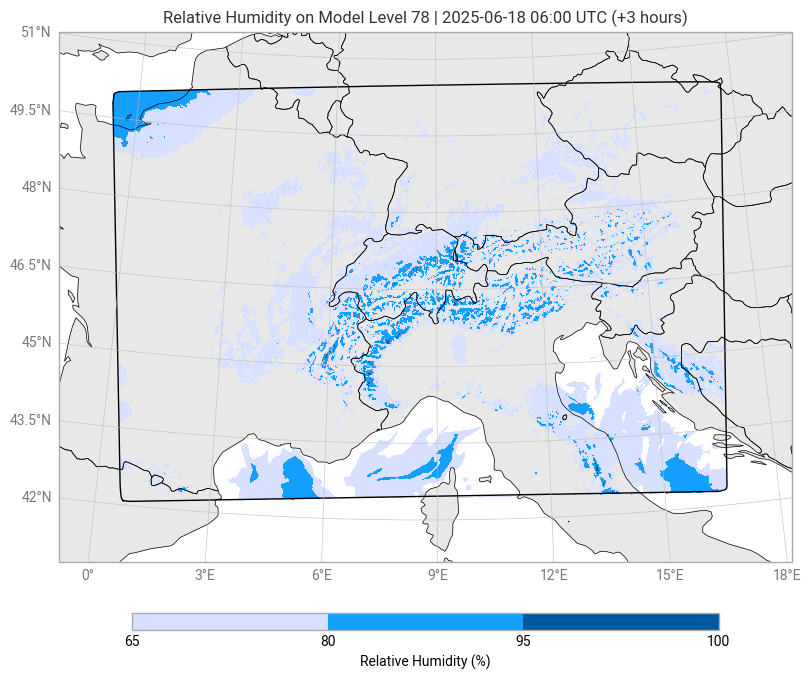

In [10]:
from earthkit.plots.geo import domains
from earthkit.plots.styles import Style
import earthkit
import pandas as pd
import cartopy.crs as ccrs

from plot_utils.load_colormaps import load_ncl_rgb_colors
from plot_utils.plot_valid_data_frame import get_valid_data_frame

# === CONFIGURATION ===
COLORMAP_NAME = "rh_3color"
FRAME_COLOR = "black"
THRESHOLD = 65

# === DOMAIN & CHART SETUP ===
domain = domains.Domain.from_bbox(bbox=[xmin, xmax, ymin, ymax], name="CH2")
chart = earthkit.plots.Map(domain=domain)

# === LOAD COLORMAP ===
rgb_colors, cmap_levels = load_ncl_rgb_colors(COLORMAP_NAME)

# === MASK RH DATA AND APPLY STYLE ===
masked_relhum = relhum_geo.where(relhum_geo > THRESHOLD)
style = Style(levels=cmap_levels, colors=rgb_colors)

chart.grid_cells(masked_relhum, x="lon", y="lat", style=style)

# === ADD FRAME AROUND VALID DATA ===
frame_polygon = get_valid_data_frame(relhum_geo)
if frame_polygon:
    x, y = frame_polygon.exterior.xy
    chart.ax.plot(x, y, color=FRAME_COLOR, linewidth=1, transform=ccrs.PlateCarree())
else:
    print("No valid frame polygon could be computed.")

# === MAP FEATURES ===
chart.land()
chart.coastlines(linewidth=0.5, color="black")
chart.borders(linewidth=0.5, color="black")
chart.gridlines()

# === METADATA & ANNOTATION ===
ref_time = pd.to_datetime(relhum_geo.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = relhum_geo.coords["lead_time"].values[0].astype('timedelta64[h]')
parameter = relhum_geo.attrs.get("parameter", {"name": "Relative Humidity", "units": "%"})

title = f"{parameter['name']} on Model Level {relhum_geo.z.values} | {ref_time} (+{lead_time})"
legend_label = f"{parameter['name']} ({parameter['units']})"

chart.title(title)
chart.legend(label=legend_label)

# === SHOW PLOT ===
chart.show()